In [1]:
import pandas as pd 
from dotenv import load_dotenv
import os 
import matplotlib.pyplot as plt
from collections import Counter
import itertools

In [ ]:
load_dotenv()

KEYWORD_DATA_PATH = os.getenv('COMPANY_DATA_PATH')

data_path = os.path.join(KEYWORD_DATA_PATH, 'Mobility.xlsx')

In [3]:
companies_df = pd.read_excel(data_path)

companies_df.columns.to_list()


['uuid',
 'name',
 'permalink',
 'country_code',
 'region',
 'NUTS2 3',
 'NUTS2 2 2021',
 'NUTS2 2016',
 'city',
 'address',
 'postal_code',
 'status',
 'num_funding_rounds',
 'total_funding_usd',
 'founded_on',
 'closed_on',
 'short_description',
 'description',
 'category_list',
 'founded_year',
 'Startup',
 'source',
 'Is_Mobility_OPENAI',
 'Is_True',
 'Digital transition',
 'Green transition',
 'Is the company engage in green or digital transition?',
 'Sector',
 'Electric mobility',
 'Autonomous driving',
 'Urban mobility',
 'EV charging ',
 'probability',
 'Unnamed: 33',
 'Probability',
 'organisation_name',
 'short_description.1']

In [4]:
stop_words = {'the', 'a','as', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'that', 'company', 'they', 'their', 'such', 'aims'}

word_counts = (companies_df['short_description']
               .str.lower()                   
               .str.replace('[^\w\s]', '', regex=True)  
               .str.split()                    
               .explode()
               .loc[lambda x: ~x.isin(stop_words)]                      
               .value_counts())


top_100 = word_counts.head(100)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/var/folders/n_/lqcbvqkd6y16c5mx9m20q7zm0000gn/T/ipykernel_66114/2986470229.py:5: SyntaxWarning: invalid escape sequence '\w'
  .str.replace('[^\w\s]', '', regex=True)


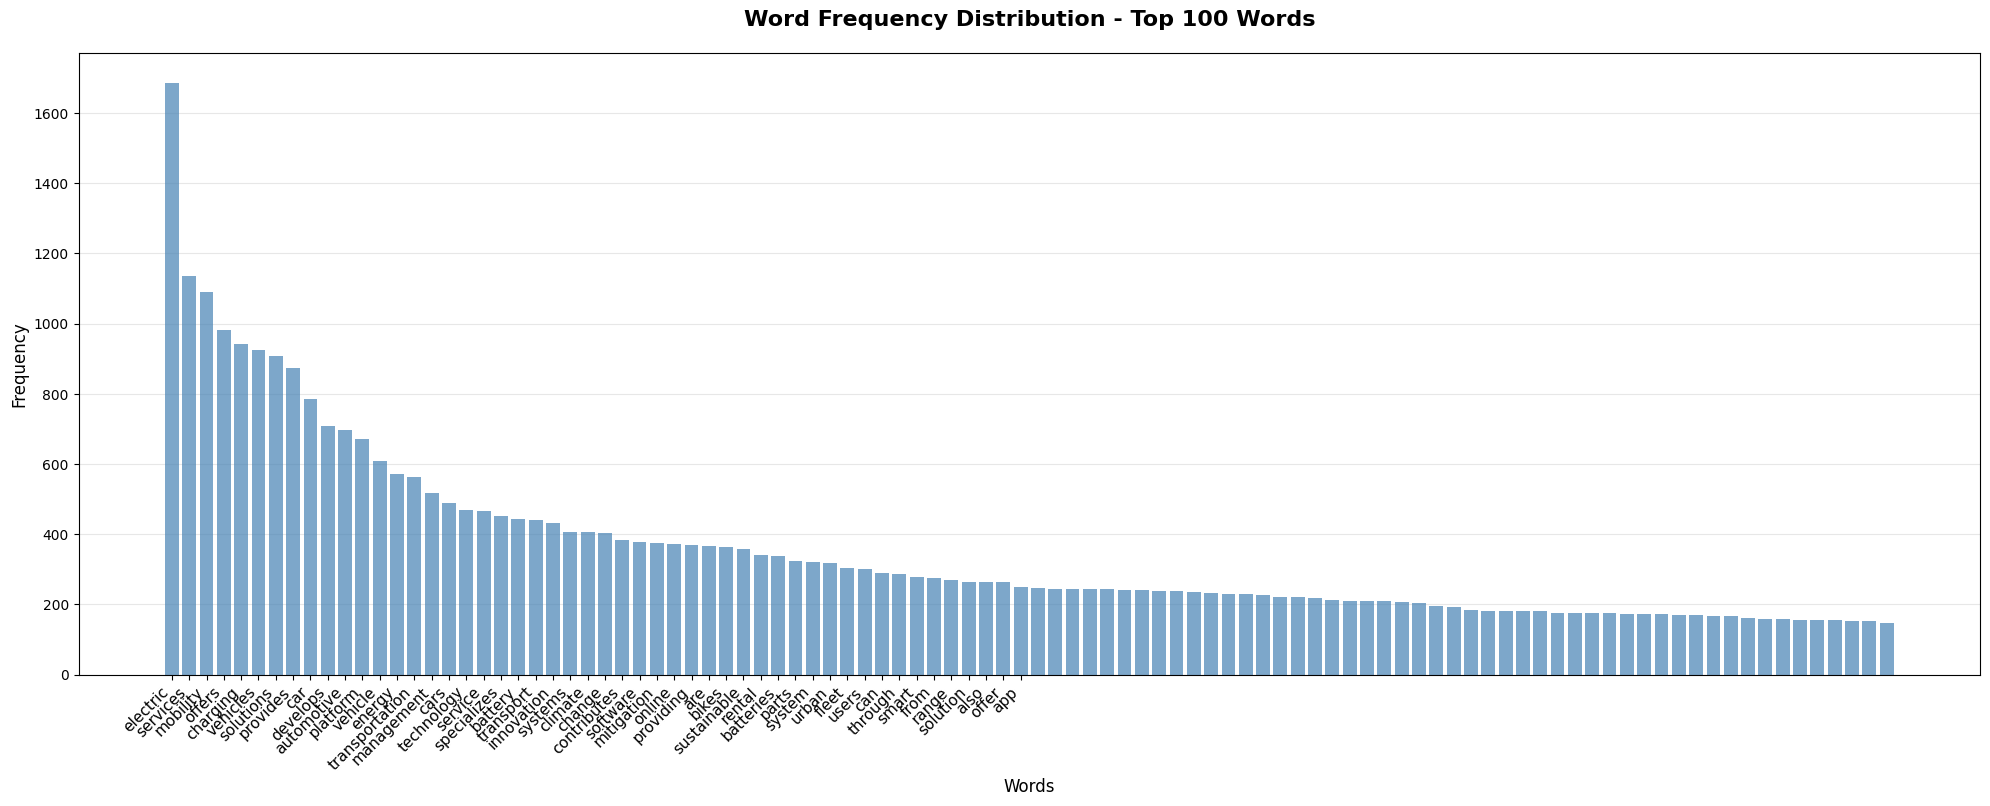

In [5]:
fig, ax = plt.subplots(figsize=(20, 8))

# Create bars - simple blue bars
bars = ax.bar(range(len(top_100)), top_100.values, 
              color='steelblue', alpha=0.7)

# Customize the plot
ax.set_title('Word Frequency Distribution - Top 100 Words', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Words', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Only show x-tick labels for top 50 with proper spacing
ax.set_xticks(range(50))
ax.set_xticklabels(top_100.index[:50], rotation=45, ha='right', fontsize=11)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Extra space for rotated labels

plt.show()

In [6]:

top_10 = list(word_counts.head(10).items())
print(top_10)

[('electric', 1685), ('services', 1136), ('mobility', 1090), ('offers', 983), ('charging', 941), ('vehicles', 926), ('solutions', 908), ('provides', 874), ('car', 785), ('develops', 707)]


In [7]:
def get_ngrams(text_series, n=2, min_freq=5):
    """Extract word combinations from text"""
    ngrams = []
    
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
                  'for', 'of', 'with', 'by', 'is', 'that', 'company', 'provides',
                  'are', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did',
                  'will', 'would', 'could', 'should', 'may', 'might', 'must',
                  'this', 'these', 'those', 'we', 'our', 'us', 'you', 'your',
                  'it', 'its', 'they', 'their', 'them'}

    for text in text_series.dropna():
        words = text.lower().split()
        
        # Clean words AND filter out stop words
        words = [word.strip('.,!?;:"()[]') for word in words 
                 
                 if len(word) > 2 and word.strip('.,!?;:"()[]') not in stop_words]
        
        # Generate n-grams
        for ngram in zip(*[words[i:] for i in range(n)]):

            ngrams.append(' '.join(ngram))
    
    # Count and filter by frequency
    ngram_counts = Counter(ngrams)
    
    return {ngram: count for ngram, count in ngram_counts.items() if count >= min_freq}



In [8]:

word_couple = get_ngrams(companies_df['short_description'], n=2, min_freq=10)

word_triple = get_ngrams(companies_df['short_description'], n=3, min_freq=5)

word_4 = get_ngrams(companies_df['short_description'], n=4, min_freq=5)

print("Top 10:")
for phrase, count in sorted(word_triple.items(), key=lambda x: x[1], reverse=True)[:50]:
    print(f"'{phrase}': {count}")

Top 10:
'contributes climate change': 375
'climate change mitigation': 375
'innovation contributes climate': 357
'develops innovation contributes': 351
'transition circular economy': 110
'eco-friendly transportation alternatives': 83
'transportation alternatives reducing': 83
'alternatives reducing emissions': 83
'electric vehicle charging': 81
'shared mobility services': 72
'circular economy providing': 68
'economy providing shared': 68
'providing shared mobility': 68
'change mitigation offering': 63
'change mitigation enabling': 61
'mitigation offering eco-friendly': 60
'offering eco-friendly transportation': 60
'change mitigation promoting': 45
'reducing emissions transition': 42
'emissions transition circular': 42
'change mitigation manufacturing': 40
'change mitigation through': 37
'mitigation enabling low-carbon': 35
'change mitigation developing': 34
'solutions electric vehicles': 30
'develops manufactures electric': 30
'adoption electric vehicles': 29
'charging stations electri

In [ ]:
def get_keyword_pairs(text_series, keywords, min_freq=1):
    """
    Find most frequent word pairs that contain any of the specified keywords
    """
    
    # Convert keywords to lowercase for matching
    keywords_lower = [keyword.lower() for keyword in keywords]
    
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 
                  'for', 'of', 'with', 'by', 'is', 'that', 'company', 'provides',
                  'are', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did',
                  'will', 'would', 'could', 'should', 'may', 'might', 'must',
                  'this', 'these', 'those', 'we', 'our', 'us', 'you', 'your',
                  'it', 'its', 'they', 'their', 'them'}
    
    pairs = []
    
    for text in text_series.dropna():
        words = text.lower().split()
        
        # Clean words and filter out stop words
        words = [word.strip('.,!?;:"()[]') for word in words 
                 if len(word) > 2 and word.strip('.,!?;:"()[]') not in stop_words]
        
        # Generate word pairs (2-grams)
        for i in range(len(words) - 1):
            word1, word2 = words[i], words[i + 1]
            
            # Check if either word is in our keywords list
            if word1 in keywords_lower or word2 in keywords_lower:
                pair = f"{word1} {word2}"
                pairs.append(pair)
    
    # Count frequencies and filter by min_freq
    pair_counts = Counter(pairs)
    filtered_pairs = {pair: count for pair, count in pair_counts.items() 
                     if count >= min_freq}
    
  
    return dict(sorted(filtered_pairs.items(), key=lambda x: x[1], reverse=True))

In [ ]:
keywords = ['online', 'e-commerce', 'retail', 'platform', 'website']

keyword_pairs = get_keyword_pairs(agri_companies['short_description'], keywords, min_freq=3)

In [ ]:
print("Most frequent word pairs containing keywords:")
for pair, count in keyword_pairs.items():
    print(f"{pair}: {count}")